In [1]:
from dotenv import load_dotenv
from langchain_groq import ChatGroq

load_dotenv()

llm = ChatGroq(model_name="llama-3.3-70b-versatile")

c:\Users\guill\GitHub\AIAssistantWithRAG\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from langchain_community.embeddings import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

C:\Users\guill\AppData\Local\Temp\ipykernel_16900\3590037574.py:3: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")


In [3]:
from langchain_chroma import Chroma

vector_store = Chroma(
    collection_name="example_collection",
    embedding_function=embeddings,
    persist_directory="./chroma_langchain_db",  # Where to save data locally, remove if not necessary
)

In [5]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

# Index chunks
_ = vector_store.add_documents(documents=all_splits)

# Define prompt for question-answering
# N.B. for non-US LangSmith endpoints, you may need to specify
# api_url="https://api.smith.langchain.com" in hub.pull.
prompt = hub.pull("rlm/rag-prompt")


# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [6]:
response = graph.invoke({"question": "What is Task Decomposition?"})
print(response["answer"])

Task decomposition is the process of breaking down a complex task into smaller, more manageable steps or subgoals. This can be achieved through various methods, including using large language models (LLMs) with simple prompting or task-specific instructions. Task decomposition helps to transform big tasks into multiple simpler tasks, making it easier to plan and execute the overall task.


In [7]:
result = graph.invoke({"question": "What is Task Decomposition?"})

print(f"Context: {result['context']}\n\n")
print(f"Answer: {result['answer']}")

Context: [Document(id='864caead-5235-474f-8f10-d0945d19ee75', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step is outsourced to an external tool, assuming the availab

In [8]:
for step in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='864caead-5235-474f-8f10-d0945d19ee75', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step is outsourced to an external tool, assu

In [9]:
for message, metadata in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="messages"
):
    print(message.content, end="|")

|Task| decomposition| is| the| process| of| breaking| down| a| complex| task| into| smaller|,| more| manageable| steps| or| sub|goals|.| This| can| be| achieved| through| various| methods|,| including| using| large| language| models| (|LL|Ms|)| with| simple| prompting| or| task|-specific| instructions|.| Task| decomposition| helps| to| make| complex| tasks| more| manageable| and| allows| for| more| effective| planning| and| problem|-solving|.||

In [10]:
from langchain_core.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

In [11]:
from typing import Literal

import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import Annotated, List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)


# Update metadata (illustration purposes)
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


# Index chunks
vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)


# Define schema for search
class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")


# Define state for application
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str


def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}


def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

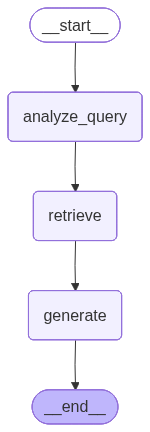

In [14]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
for step in graph.stream(
    {"question": "What does the end of the post say about Task Decomposition?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'Task Decomposition', 'section': 'end'}}}

----------------

{'retrieve': {'context': [Document(id='a99b05d6-5577-4f6a-9514-fefb4da6b031', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'section': 'end'}, page_content='Finite context length: The restricted context capacity limits the inclusion of historical information, detailed instructions, API call context, and responses. The design of the system has to work with this limited communication bandwidth, while mechanisms like self-reflection to learn from past mistakes would benefit a lot from long or infinite context windows. Although vector stores and retrieval can provide access to a larger knowledge pool, their representation power is not as powerful as full attention.\n\n\nChallenges in long-term planning and task decomposition: Planning over a lengthy history and effectively exploring the solution space remain challenging. LLMs struggle to adjust plans when faced w